In [3]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA

In [4]:
hidden_dim = 32

# face locations matrix
x = np.array([[i,j] for i in range(1,5) for j in range(1,5)])
x_c = x - np.mean(x)

# random projection matrices
w1 = np.random.rand(2,hidden_dim // 2)
w1[1,:] = 0
w2 = np.random.rand(2,hidden_dim // 2)
w2[0,:] = 0

# hidden layers
h1 = x_c @ w1
h2 = x_c @ w2
h_baseline = np.concatenate([h1,h2], axis=1)


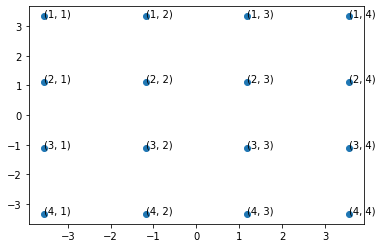

In [5]:
# PCA
pca = PCA(n_components=2)
embeds = pca.fit_transform(h_baseline)

# Plot
fix, ax = plt.subplots()
ax.scatter(embeds[:,0],embeds[:,1])
for loc,emb in zip(x,embeds):
    ax.annotate(tuple(loc), tuple(emb))
plt.show()

In [6]:
# Scaled grid
gamma = 0.5

h1_popularity = x_c @ w1 * gamma
h2_popularity = x_c @ w2
h_popularity = np.concatenate([h1_popularity, h2_popularity], axis=1)

h1_competence = x_c @ w1
h2_competence = x_c @ w2 * gamma
h_competence = np.concatenate([h1_competence, h2_competence], axis=1)

h = np.concatenate([h_popularity, h_competence], axis=0)

# Baseline
h1_popularity_b = x_c @ w1
h2_popularity_b = x_c @ w2
h_popularity_b = np.concatenate([h1_popularity_b, h2_popularity_b], axis=1)

h1_competence_b = x_c @ w1
h2_competence_b = x_c @ w2
h_competence_b = np.concatenate([h1_competence_b, h2_competence_b], axis=1)

h_b = np.concatenate([h_popularity_b, h_competence_b], axis=0)

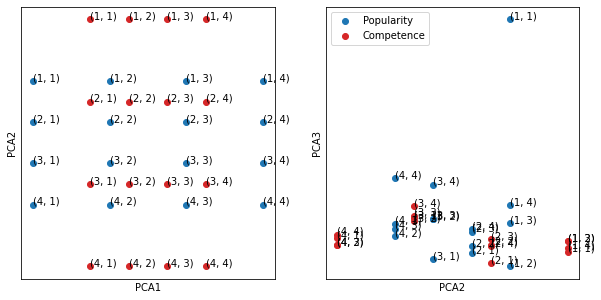

In [7]:
# PCA
pca = PCA(n_components=3)
embeds = pca.fit_transform(h)

# Plot
locs = [tuple(x_i) for x_i in x] * 2
fix, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(embeds[:16,0],embeds[:16,1], c='tab:blue')
ax[0].scatter(embeds[16:,0],embeds[16:,1], c='tab:red')
for loc,emb in zip(locs,embeds):
    ax[0].annotate(loc, tuple(emb[0:2]))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('PCA1')
ax[0].set_ylabel('PCA2')

ax[1].scatter(embeds[:16,1],embeds[:16,2], c='tab:blue')
ax[1].scatter(embeds[16:,1],embeds[16:,2], c='tab:red')
ax[1].legend(['Popularity', 'Competence'])
for loc,emb in zip(locs,embeds):
    ax[1].annotate(loc, tuple(emb[1:3]))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('PCA2')
ax[1].set_ylabel('PCA3')
plt.show()

### Simulate regression analysis

In [8]:
# Get distances
x_e = [] # 2D Euclidean distances
x_r1 = [] # 1D Rank differences (competence)
x_r2 = [] # 1D Rank differences (popularity)
dists_p = []
dists_c = []
for idx1, idx2 in combinations(range(16),2):
    x_e.append(np.linalg.norm(x[idx1] - x[idx2]))
    x_r1.append(abs(x[idx1][0] - x[idx2][0]))
    x_r2.append(abs(x[idx1][1] - x[idx2][1]))
    
    f1_p = h_popularity[idx1]
    f2_p = h_popularity[idx2]
    dist_p = np.linalg.norm(f1_p - f2_p)
    dists_p.append(dist_p)
    
    f1_c = h_competence[idx1]
    f2_c = h_competence[idx2]
    dist_c = np.linalg.norm(f1_c - f2_c)
    dists_c.append(dist_c)


In [9]:
dependent = np.array(dists_p + dists_c)
x_r = np.expand_dims(np.array(x_r2 + x_r1), axis=1)
x_e = np.expand_dims(np.array(x_e + x_e), axis=1)
independent = np.concatenate([x_r, x_e], axis=1)
independent = sm.add_constant(independent)

In [10]:
stats_model = sm.OLS(dependent,independent).fit()         
print(stats_model.pvalues)
print(stats_model.tvalues)
print(stats_model.params) 
print(stats_model.bse)

[4.25509080e-004 3.64256673e-155 1.12699462e-125]
[ 3.5742472  66.41577506 48.8272249 ]
[0.12625093 1.19995233 0.96317361]
[0.03532238 0.01806728 0.01972616]


### Results for simple grid

In [11]:
# Get distances
x_e = [] # 2D Euclidean distances
x_r1 = [] # 1D Rank differences (competence)
x_r2 = [] # 1D Rank differences (popularity)
dists_p = []
dists_c = []
for idx1, idx2 in combinations(range(16),2):
    x_e.append(np.linalg.norm(x[idx1] - x[idx2]))
    x_r1.append(abs(x[idx1][0] - x[idx2][0]))
    x_r2.append(abs(x[idx1][1] - x[idx2][1]))
    
    f1_p = h_popularity_b[idx1]
    f2_p = h_popularity_b[idx2]
    dist_p = np.linalg.norm(f1_p - f2_p)
    dists_p.append(dist_p)
    
    f1_c = h_competence_b[idx1]
    f2_c = h_competence_b[idx2]
    dist_c = np.linalg.norm(f1_c - f2_c)
    dists_c.append(dist_c)


dependent = np.array(dists_p + dists_c)
x_r = np.expand_dims(np.array(x_r2 + x_r1), axis=1)
x_e = np.expand_dims(np.array(x_e + x_e), axis=1)
independent = np.concatenate([x_r, x_e], axis=1)
independent = sm.add_constant(independent)

stats_model = sm.OLS(dependent,independent).fit()         
print(stats_model.pvalues)
print(stats_model.tvalues)
print(stats_model.params) 
print(stats_model.bse)

[9.76602097e-001 9.75888366e-001 1.61238494e-270]
[-2.93601075e-02  3.02559805e-02  2.08515370e+02]
[-5.78646544e-04  3.05006927e-04  2.29501924e+00]
[0.0197086  0.01008088 0.01100648]
